## CNN text classification on Amazon food reviews

Literature on CNNs for NLP tasks:

1) http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

2) https://arxiv.org/pdf/1404.2188.pdf

3) https://arxiv.org/pdf/1408.5882.pdf

4) http://cs224d.stanford.edu/reports/RhodesDylan.pdf

5) http://cs224d.stanford.edu/reports/DufourNick.pdf


Word2vec explained:
- http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
- http://stats.stackexchange.com/questions/244616/how-sampling-works-in-word2vec-can-someone-please-make-me-understand-nce-and-ne/245452#245452

How to use tensorboard:
- http://ischlag.github.io/2016/06/04/how-to-use-tensorboard/

Inspired by:
- http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
- https://agarnitin86.github.io/blog/2016/12/23/text-classification-cnn

In [2]:
import pandas as pd
from helpers import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk import FreqDist
import operator
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

/home/vecht499/anaconda/envs/py35/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == labels) / predictions.shape[0])

## Load dataset & process it

In [4]:
df = pd.read_csv("../data/Reviews.csv")
df.columns = map(lambda x: x.lower(), df.columns)

In [8]:
## remove nan reviews
df = df[pd.notnull(df.text)].reset_index(drop=True).copy()

In [27]:
## create numerical categories
df["cat1_num"] = df['cat1'].astype('category').cat.codes
df["cat2_num"] = df['cat2'].astype('category').cat.codes

In [28]:
df.head()

,productid,title,userid,helpfulness,score,text,cat1,cat2,cat3,text_length,text_adj,cat1_num,cat2_num
0,B0000DF3IX,Paprika Hungarian Sweet,A244MHL2UN2EYL,0/0,5.0,while in hungary we were given a recipe for hu...,grocery gourmet food,herbs,spices seasonings,32,while in hungary we were given a recipe for hu...,2,35
1,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A3FL7SXVYMC5NR,3/3,5.0,without a doubt i would recommend this wholeso...,grocery gourmet food,breakfast foods,cereals,38,without a doubt i would recommend this wholeso...,2,12
4,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),AUGT2DOGKLHIN,2/2,5.0,and i ve tried alot of cereals this is by far ...,grocery gourmet food,breakfast foods,cereals,43,and i ve tried alot of cereals this is by far ...,2,12
5,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A3BLSHNN3M27VI,2/2,5.0,oh s has been my favorite cereal as a kid and ...,grocery gourmet food,breakfast foods,cereals,26,oh s has been my favorite cereal as a kid and ...,2,12
6,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A2PNSZA0JC343L,2/3,5.0,this cereal is great because it tastes so good...,grocery gourmet food,breakfast foods,cereals,18,this cereal is great because it tastes so good...,2,12


In [10]:
df["text"] = df["text"].apply(lambda x: cleanData(x))
df["text_length"] = df["text"].apply(lambda x: getSentenceLength(x))

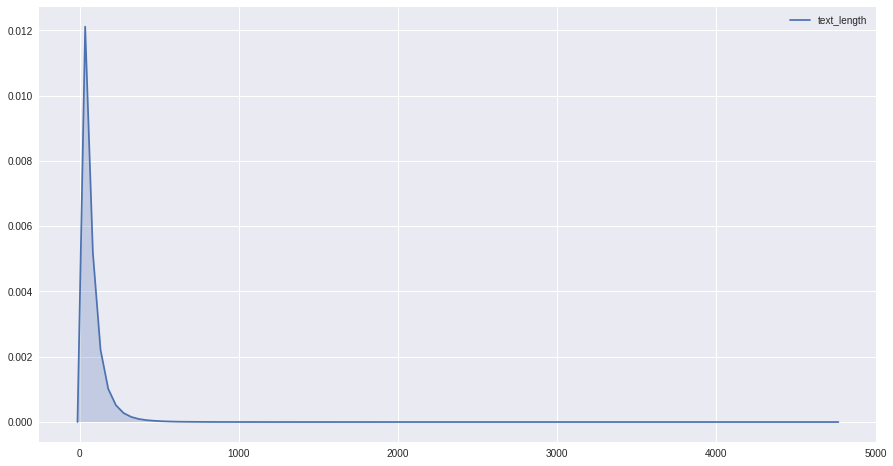

In [11]:
## review length distribution
plt.figure(figsize=(15,8))
sns.kdeplot(df.text_length, shade=True)

In [12]:
## remove reviews with length more than 100
df = df[df.text_length<=100].copy()
## if length of a review is shorter than 100; fill it in with placeholer words
df["text_adj"] = df["text"].apply(lambda x: add_placeholders(x, 100))

In [13]:
df.head(2)

,productid,title,userid,helpfulness,score,text,cat1,cat2,cat3,text_length,text_adj
0,B0000DF3IX,Paprika Hungarian Sweet,A244MHL2UN2EYL,0/0,5.0,while in hungary we were given a recipe for hu...,grocery gourmet food,herbs,spices seasonings,32,while in hungary we were given a recipe for hu...
1,B0002QF1LK,Quaker Honey Graham Oh's 10.5 oz - (6 pack),A3FL7SXVYMC5NR,3/3,5.0,without a doubt i would recommend this wholeso...,grocery gourmet food,breakfast foods,cereals,38,without a doubt i would recommend this wholeso...


In [14]:
## create word count dictionary for all reviews
word_dist = FreqDist()
for s in df.text_adj:
    word_dist.update(s.split())

## replace rare words (occur only once)
words_to_replace = [k for k, v in dict(word_dist).items() if v == 1]

word_lookup = dict()
for word in dict(word_dist).keys():
    if word in words_to_replace:
        word_lookup[word] = "rarewordplaceholder"
    else:
        word_lookup[word] = word

def replace_words(strg, words_to_replace):
    line = strg.split()
    line = [word_lookup[x] for x in line]
    result = ' '.join(line)
    return result

df["text_adj"] = df["text_adj"].apply(lambda x: replace_words(x, words_to_replace))

In [15]:
## create word count dictionary for all reviews
word_dist = FreqDist()
for s in df.text_adj:
    word_dist.update(s.split())

## take a look at dictionary
sorted_x = sorted(dict(word_dist).items(), key=operator.itemgetter(1))
print(sorted_x)

[('whittier', 2), ('vew', 2), ('dorks', 2), ('frontine', 2), ('splend', 2), ('marcella', 2), ('rehearse', 2), ('gulfstream', 2), ('nonethe', 2), ('ound', 2), ('psre', 2), ('obtw', 2), ('detecto', 2), ('datesecond', 2), ('woild', 2), ('seizers', 2), ('dens', 2), ('hertiage', 2), ('memy', 2), ('amazonto', 2), ('articial', 2), ('impractible', 2), ('onely', 2), ('petbuddy', 2), ('ikeep', 2), ('thebutton', 2), ('termo', 2), ('decifer', 2), ('onlygoes', 2), ('quirt', 2), ('closereuro', 2), ('todrink', 2), ('eckobrew', 2), ('usableamount', 2), ('patronage', 2), ('responsed', 2), ('vareity', 2), ('stabilising', 2), ('cyclinder', 2), ('screwball', 2), ('colher', 2), ('finnex', 2), ('foundthem', 2), ('nationalities', 2), ('weightfinish', 2), ('colazal', 2), ('scraves', 2), ('blackwhich', 2), ('contertop', 2), ('lawrys', 2), ('nizor', 2), ('obello', 2), ('screwup', 2), ('hickups', 2), ('envoy', 2), ('wouid', 2), ('nutzo', 2), ('uniquewhen', 2), ('cinnemon', 2), ('quaffing', 2), ('bakehouse', 2), 

In [16]:
vocab = dict()
for e,y in enumerate(dict(word_dist).keys()):
    vocab[y]=e

In [17]:
len(vocab)

97382

In [18]:
vocab

{'label': 0,
 'acquires': 2,
 'hawed': 3,
 'employee': 4,
 'liners': 5,
 'whittier': 6,
 'vew': 7,
 'skewing': 8,
 'officemates': 9,
 'counselors': 10,
 'decade': 11,
 'hander': 15893,
 'calaphalon': 13,
 'inconvient': 14,
 'stows': 15,
 'frontine': 16,
 'splend': 17,
 'cyclinder': 122,
 'marcella': 19,
 'deployments': 20,
 'thedoor': 21,
 'bullseye': 23,
 'gulfstream': 24,
 'pelo': 31963,
 'artland': 26,
 'nonethe': 27,
 'ouidad': 28,
 'raincover': 29,
 'esterilizador': 80597,
 'hammerheads': 31,
 'ound': 32,
 'stuffing': 33,
 'universal': 34,
 'psre': 35,
 'etheral': 201,
 'assam': 37,
 'blinding': 38,
 'mercurochrome': 220,
 'makerthe': 40,
 'datesecond': 41,
 'negocios': 233,
 'marinates': 43,
 'subtle': 44,
 'beared': 45,
 'scrath': 46,
 'thermus': 47,
 'woild': 48,
 'thanksmsladyjae': 49,
 'light': 50,
 'rtfm': 51,
 'stitch': 52,
 'elaborate': 53,
 'propane': 54,
 'seizers': 55,
 'teas': 56,
 'dens': 57,
 'procesador': 58,
 'aden': 59,
 'hertiage': 60,
 'bottim': 35162,
 'prepack

## Prepare train/test dataset

In [19]:
## map each sentence to a vector of words:
sentence_vecs = np.array(df["text_adj"].apply(lambda x: create_sentence_vectors(x, vocab)).tolist())

In [20]:
sentence_vecs

array([[  644, 54996, 56317, ..., 16060, 16060, 16060],
       [28631, 53343, 87139, ..., 16060, 16060, 16060],
       [71782, 40398,  4951, ..., 16060, 16060, 16060],
       ..., 
       [40398, 14436, 14171, ..., 16060, 16060, 16060],
       [40398, 12956, 80640, ..., 16060, 16060, 16060],
       [40398, 14171, 51369, ..., 16060, 16060, 16060]])

In [43]:
label_vecs = np.array([df.cat1_num.tolist(),df.cat2_num.tolist()]).transpose()

In [46]:
label_vecs.shape

(1532597, 2)

In [45]:
label_vecs

array([[ 2, 35],
       [ 2, 12],
       [ 2, 12],
       ..., 
       [ 0, 22],
       [ 0, 22],
       [ 0, 22]])

In [47]:
## train-valid-test split
train_dataset, test_dataset, train_labels, test_labels = \
                            train_test_split(sentence_vecs, label_vecs, test_size=0.3, random_state=0)
test_dataset, valid_dataset, test_labels, valid_labels = \
                            train_test_split(test_dataset, test_labels, test_size=0.33, random_state=0)

In [48]:
print ("Size of train set: %s" % len(train_dataset))
print ("Size of test set: %s" % len(test_dataset))
print ("Size of validation set: %s" % len(valid_dataset))

Size of train set: 1072817
Size of test set: 308052
Size of validation set: 151728


In [49]:
train_dataset, train_labels

(array([[ 2362, 55976,  6167, ..., 16060, 16060, 16060],
        [24222, 32544, 35947, ..., 16060, 16060, 16060],
        [51369, 38282, 35947, ..., 16060, 16060, 16060],
        ..., 
        [29641, 72272, 14138, ..., 16060, 16060, 16060],
        [92211, 71782, 31969, ..., 16060, 16060, 16060],
        [40398, 92876, 14171, ..., 16060, 16060, 16060]]), array([[ 3, 50],
        [ 4, 40],
        [ 3, 50],
        ..., 
        [ 5, 16],
        [ 0, 56],
        [ 4, 40]]))

In [66]:
train_labels_cat1 = np.array([[x[0]] for x in train_labels])
valid_labels_cat1 = np.array([[x[0]] for x in valid_labels])
test_labels_cat1 = np.array([[x[0]] for x in test_labels])

train_labels_cat2 = np.array([[x[1]] for x in train_labels])
valid_labels_cat2 = np.array([[x[1]] for x in valid_labels])
test_labels_cat2 = np.array([[x[1]] for x in test_labels])

## Ready for tensorflow!

### 1. Predict Cat1
### 2. Predict Cat2
### 3. Predict Cat2 & Cat1 together -> improvement?
### Baseline model to compare: TF-IDF with Naive Bayes/ TF-IDF with Random Forest

In [22]:
SEQ_LENGTH = 200
BATCH_SIZE = 50
NUM_LABELS = 2

VOCAB_SIZE = len(vocab)
EMBED_SIZE = 128

FILTER_SIZE_1 = 3
FILTER_SIZE_2 = 4
FILTER_SIZE_3 = 5
NUM_FILTERS = 128

keep_prob = 0.8

tf_train_dataset = tf.placeholder(tf.int32, shape=(BATCH_SIZE, SEQ_LENGTH))
tf_train_labels = tf.placeholder(tf.int32, shape=(BATCH_SIZE))
tf_valid_dataset = tf.constant(valid_dataset) 
tf_test_dataset = tf.constant(test_dataset)

# Keeping track of l2 regularization loss (optional)
#l2_loss = tf.constant(0.0)

## Embedding layer

embed_weigths = tf.Variable(tf.random_uniform([VOCAB_SIZE, EMBED_SIZE], -1.0, 1.0))
    
## Convolutional layers
## Change to True if run again
with tf.variable_scope("vars", reuse = None):
    
    conv1_weights = tf.get_variable("conv1_w", shape=[FILTER_SIZE_1, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv1_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv1_b")

    conv2_weights = tf.get_variable("conv2_w", shape=[FILTER_SIZE_2, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv2_b")

    conv3_weights = tf.get_variable("conv3_w", shape=[FILTER_SIZE_3, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv3_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv3_b")

## Fully connected layer

    fc1_weights = tf.get_variable("fc1_w", shape=[3*NUM_FILTERS, NUM_LABELS],\
                                                initializer=tf.contrib.layers.xavier_initializer())
    fc1_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]), name = "fc1_b")

# Model:
def model(data, keep_prob = keep_prob): 
    
    ## Embedding layer
    ## input shape:[BATCH_SIZE, SEQ_LENGTH]
    ## output shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    
    with tf.device('/cpu:0'), tf.name_scope("embedding"):    
        embed_chars = tf.nn.embedding_lookup(embed_weigths, data)
        embed_chars = tf.expand_dims(embed_chars, -1)
    
    ## Conv1+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    conv1 = tf.nn.conv2d(embed_chars, conv1_weights, strides=[1, 1, 1, 1], padding="VALID")
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
    pool1 = tf.nn.max_pool(relu1, ksize=[1, SEQ_LENGTH-FILTER_SIZE_1+1, 1, 1],
                           strides=[1, 1, 1, 1], padding='VALID')
    ## Conv2+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    conv2 = tf.nn.conv2d(embed_chars, conv2_weights, strides=[1, 1, 1, 1], padding="VALID")
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
    pool2 = tf.nn.max_pool(relu2, ksize=[1, SEQ_LENGTH-FILTER_SIZE_2+1, 1, 1],
                           strides=[1, 1, 1, 1], padding='VALID')
    
    ## Conv3+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    conv3 = tf.nn.conv2d(embed_chars, conv3_weights, strides=[1, 1, 1, 1], padding="VALID")
    relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_biases))
    pool3 = tf.nn.max_pool(relu3, ksize=[1, SEQ_LENGTH-FILTER_SIZE_3+1, 1, 1],
                           strides=[1, 1, 1, 1], padding='VALID')
    
    ## Combine pooled features + flatten
    ## input shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    ## output shape: [BATCH_SIZE, 3, 1, 1, NUM_FILTERS]
    
    pooled_outputs = [pool1, pool2, pool3]
    h_pool = tf.concat(pooled_outputs,3)
    h_pool_flat = tf.reshape(h_pool, [-1, NUM_FILTERS*3])
    h_pool_flat = tf.nn.dropout(h_pool_flat, keep_prob)
    
    ## Fully connected layer
    return tf.matmul(h_pool_flat, fc1_weights) + fc1_biases  
  
# Training computation:
logits = model(tf_train_dataset)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
  
# Optimizer:
optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

# with tf.name_scope("output"):
#            W = tf.get_variable(
#                "W",
#                shape=[num_filters_total, num_classes],
#                initializer=tf.contrib.layers.xavier_initializer())
#            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
#            l2_loss += tf.nn.l2_loss(W)
#            l2_loss += tf.nn.l2_loss(b)
#            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
#            self.predictions = tf.argmax(self.scores, 1, name="predictions")
#
#        # CalculateMean cross-entropy loss
#        with tf.name_scope("loss"):
#            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
#            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


In [23]:
## remove objects from memory
del word_dist
del word_lookup

**Predictions for the training, validation, and test data**

In [24]:
train_prediction = tf.nn.softmax(logits)
valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
test_prediction = tf.nn.softmax(model(tf_test_dataset))

## Train model and report accuracy

In [30]:
NUM_ITERATIONS = 1001

step = []
pred = []
loss_minibatch = []
accuracy_minibatch = []
accuracy_valid = []

logs_path = '../tensorflow_logs/example'

with tf.Session() as session:
    tf.global_variables_initializer().run()
    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    for i in range(NUM_ITERATIONS):
        offset = (i * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict) 
        
        if (i % 200 == 0): ## info will be printed every 1000th time
            #predictions = np.argmax(predictions, 1)
            step.append(i)
            print("Minibatch loss at step %d: %f" % (i, l))
            loss_minibatch.append(l)
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            accuracy_minibatch.append(accuracy(predictions, batch_labels))
            #print("Minibatch f1 score: %.1f%%" % f1_score(predictions, batch_labels))
            #accuracy_minibatch.append(f1_score(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))    
            accuracy_valid.append(accuracy(valid_prediction.eval(), valid_labels))
            #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))    
            #accuracy_valid.append(accuracy(valid_prediction.eval(), valid_labels))
            
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    
    #save_path = saver.save(session, "../models/SVHN_MODEL.ckpt")
    #print("Model saved in file: %s" % save_path)
    
    #pred.append(test_prediction.eval(), 1)
    
    print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs " \
          "\nThen open http://172.26.179.29:6006/ into your web browser")

#pred = pred[0]

#def accuracy(predictions, labels):
#    return (100.0 * np.sum(np.argmax(predictions, 1) == labels) / predictions.shape[0])

Minibatch loss at step 0: 0.718236
Minibatch accuracy: 46.0%
Validation accuracy: 63.9%
Validation accuracy: 64.1%
Minibatch loss at step 200: 0.391989
Minibatch accuracy: 84.0%
Validation accuracy: 84.6%
Validation accuracy: 84.6%
Minibatch loss at step 400: 0.283092
Minibatch accuracy: 90.0%
Validation accuracy: 85.1%
Validation accuracy: 85.0%
Minibatch loss at step 600: 0.260687
Minibatch accuracy: 90.0%
Validation accuracy: 85.1%
Validation accuracy: 85.1%
Minibatch loss at step 800: 0.201020
Minibatch accuracy: 94.0%
Validation accuracy: 85.9%
Validation accuracy: 86.0%
Minibatch loss at step 1000: 0.390799
Minibatch accuracy: 84.0%
Validation accuracy: 86.9%
Validation accuracy: 86.7%

Test accuracy: 86.8%


TypeError: append() takes exactly one argument (2 given)

In [78]:
pred

[]

In [32]:
print precision_score(test_labels, pred)
print recall_score(test_labels, pred)
print accuracy_score(test_labels, pred)
print f1_score(test_labels, pred)
confusion_matrix(test_labels, pred)

0.820322443784
0.628167641326
0.921990049751
0.711499540018


array([[33197,   847],
       [ 2289,  3867]])

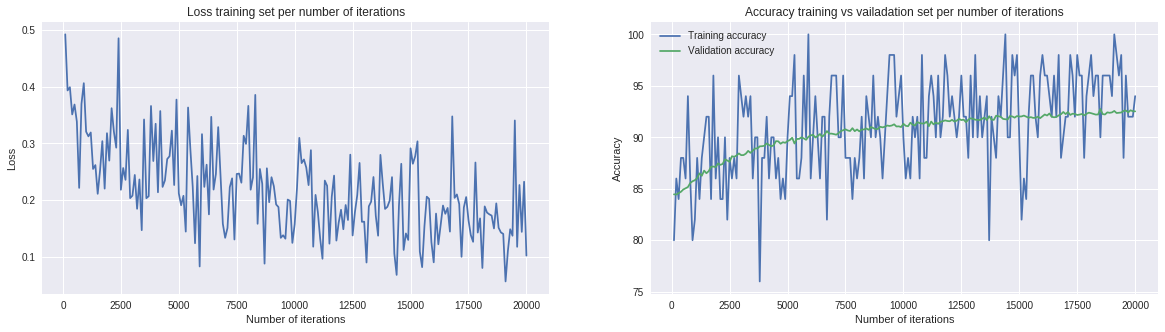

In [35]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(step[1:len(step)],loss_minibatch[1:len(step)])
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.title('Loss training set per number of iterations')

plt.subplot(1, 2, 2)
plt.plot(step[1:len(step)],accuracy_minibatch[1:len(step)], label = 'Training accuracy')
plt.plot(step[1:len(step)],accuracy_valid[1:len(step)], label = 'Validation accuracy')
plt.legend(loc = 0)
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy training vs vailadation set per number of iterations')